Snippet to load and visualize the dataset


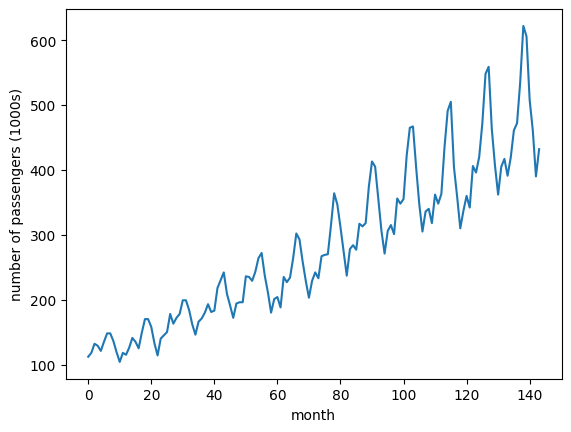

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import blocks
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import blocks
import utils

##use this only if you didn't download yet the csv file##
##!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

training_set = pd.read_csv('./Datasets/Airline-passengers/airline-passengers.csv')

training_set = training_set.iloc[:,1:2].values
#print(training_set[0])

plt.xlabel('month')
plt.ylabel('number of passengers (1000s)')
plt.plot(training_set)
plt.show()

Preprocessing


In [2]:


sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 32 #it is tau in the paper
x, y = utils.sliding_windows(training_data, seq_length)


train_size=len(y) -36            #like in the paper
test_size = len(y) - train_size

dataX = torch.Tensor(np.array(x))
dataY = torch.Tensor(np.array(y))

trainX = torch.Tensor(np.array(x[0:train_size]))
trainY = torch.Tensor(np.array(y[0:train_size]))

testX = torch.Tensor(np.array(x[train_size:len(x)]))
testY = torch.Tensor(np.array(y[train_size:len(y)]))

print(training_data.shape)   
print(dataX.shape)          
print(dataY.shape)
print('TrainX:',trainX.shape)               #batch_size, history_length, num_features)
print(trainY.shape)
print(trainX.size(0))

(144, 1)
torch.Size([111, 32, 1])
torch.Size([111, 1])
TrainX: torch.Size([75, 32, 1])
torch.Size([75, 1])
75


Create real sequences

In [3]:
sequences=utils.real_seq(training_data,seq_length)
sequences=sequences[:75]
print(sequences.dtype)
sequences=torch.Tensor(sequences)
sequences.unsqueeze(0).unsqueeze(1)
sequences=sequences.permute(0,2,1)
print(sequences.shape)

'''#sanity check don't uncomment
sequences=sequences.permute(0,2,1)
print(sequences[98])
print(training_data[106:114])
plt.plot(sequences[2])
'''


float64
torch.Size([75, 1, 32])


"#sanity check don't uncomment\nsequences=sequences.permute(0,2,1)\nprint(sequences[98])\nprint(training_data[106:114])\nplt.plot(sequences[2])\n"

p.shape: torch.Size([75, 32, 1])


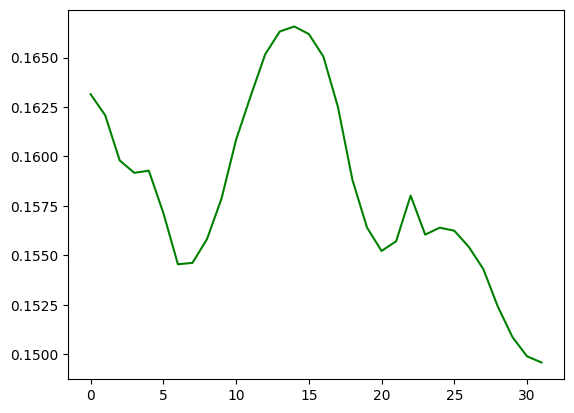

In [4]:
#embed the input
embedding_dim=10
batch_size=trainX.size(0)
value_features=1
key_features=1



#extract the number of features
num_features=trainX.size(2)+10  #features+embedding+noise(?)


#Generator
G=blocks.Generator(embedding_dim,seq_length,num_features,batch_size,value_features,key_features)
p=G(trainX)

p=p.permute(0,2,1)

#plot the results
plt.plot(p[0].detach().numpy(),color="green")
print("p.shape:",p.shape)

# *Train*

### Moment loss

In [5]:
def moment_loss(fake_data, real_data):
    fake_mean = fake_data.mean()
    real_mean = real_data.mean()
    fake_std = fake_data.std()
    real_std = real_data.std()
    return abs(fake_mean - real_mean) + abs(fake_std - real_std)

### Path model save

In [6]:
path="Models/Airline_Passengers"
utils.create_folder(path)

The new models directory is created!


In [7]:
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
#Hyperparameters
discriminator_lr=0.005
#generator_lr=0.00005
generator_lr=0.005
num_epochs=60
batch_size=75
criterion = nn.MSELoss()

#Initializations
train_set = TensorDataset(trainX, sequences)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False) 


D = blocks.Discriminator(embedding_dim,seq_length,num_features,batch_size,value_features,key_features)
G=blocks.Generator(embedding_dim,seq_length,num_features,batch_size,value_features,key_features)
optimD = Adam(D.parameters(), lr=discriminator_lr, betas=(0.9, 0.999))
optimG = Adam(G.parameters(), lr=generator_lr, betas=(0.9, 0.999))


#Training
g_losses = []
d_losses = []
save=True
for epoch in (range(num_epochs)):
        g_loss_min=1000000
        d_loss_min=1000000
        g_losses_temp=[]
        d_losses_temp=[]
        for i, (X, Y) in enumerate((train_loader)):
            #print("i:",i)
            #print("X in (train_loader):",X.shape)
            #print("Y:",Y.shape)
            
              
            # Generate fake data
            fake_data = G(X)
            fake_label = torch.zeros(Y.size(0))
            
            # Train the discriminator
            D.zero_grad()

            d_real_loss = criterion(D(Y,X), torch.ones_like(D(Y,X)))
            d_fake_loss = criterion(D(fake_data.detach(),X), torch.zeros_like(D(fake_data.detach(),X)))
            d_loss = d_real_loss + d_fake_loss

            d_losses_temp.append(d_loss.item())
            
            d_loss.backward(retain_graph=False)
            optimD.step()
            
            # Train the generator
            G.zero_grad()
            g_loss = criterion(D(fake_data,X), torch.ones_like(D(fake_data,X)))
            
            # Add the moment loss
            g_loss += moment_loss(fake_data, Y)
            #g_loss = moment_loss(fake_data, Y)
            g_losses_temp.append(g_loss.item())

            if(g_loss<g_loss_min and d_loss<d_loss_min and save):
                g_loss_min = g_loss
                d_loss_min = d_loss
                torch.save(G.state_dict(), path+'/generator.pt')
                torch.save(G, path+'/generator_model.pt')
                torch.save(D.state_dict(), path+'/discriminator.pt')
                torch.save(D, path+'/discriminator_model.pt')
                print('Improvement-Detected, model saved')

            g_loss.backward()
            optimG.step()
            
            # Print the losses
            if (i+1) % 1 == 0:
                print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % 
                    (epoch+1, num_epochs, i+1, len(train_loader), d_loss.item(), g_loss.item()))
        g_losses.append(torch.mean(torch.Tensor(g_losses_temp)))
        d_losses.append(torch.mean(torch.Tensor(d_losses_temp)))

Improvement-Detected, model saved
[Epoch 1/60] [Batch 1/1] [D loss: 1.457676] [G loss: 2.152697]
Improvement-Detected, model saved
[Epoch 2/60] [Batch 1/1] [D loss: 1.442927] [G loss: 1.895466]
Improvement-Detected, model saved
[Epoch 3/60] [Batch 1/1] [D loss: 1.428701] [G loss: 1.758595]
Improvement-Detected, model saved
[Epoch 4/60] [Batch 1/1] [D loss: 1.408868] [G loss: 1.556985]
Improvement-Detected, model saved
[Epoch 5/60] [Batch 1/1] [D loss: 1.372346] [G loss: 1.330445]
Improvement-Detected, model saved
[Epoch 6/60] [Batch 1/1] [D loss: 1.316401] [G loss: 1.458652]
Improvement-Detected, model saved
[Epoch 7/60] [Batch 1/1] [D loss: 1.237286] [G loss: 1.353083]
Improvement-Detected, model saved
[Epoch 8/60] [Batch 1/1] [D loss: 1.140980] [G loss: 1.150101]
Improvement-Detected, model saved
[Epoch 9/60] [Batch 1/1] [D loss: 1.021599] [G loss: 0.952136]
Improvement-Detected, model saved
[Epoch 10/60] [Batch 1/1] [D loss: 0.887695] [G loss: 0.731108]
Improvement-Detected, model s

End-training Generator Loss: tensor(0.2703)
End-training Discriminator Loss: tensor(0.5004)


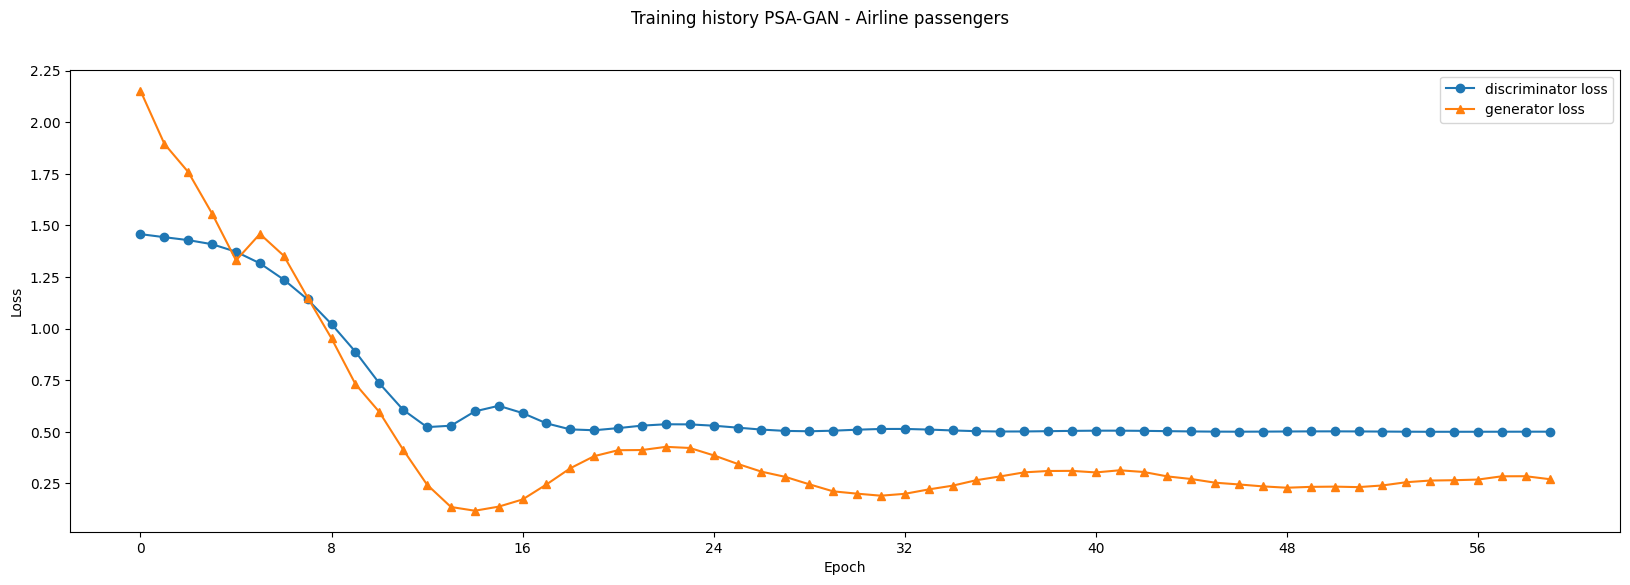

In [8]:

utils.plot_training_history('PSA-GAN - Airline passengers',d_losses, g_losses)


In [9]:

# Use the trained generator to generate new time series samples
with torch.no_grad():
    
    
    generated_series = G(dataX[:batch_size]) #substitue trainX with testX
    generated_series=generated_series.permute(0,2,1)
    print("generated_series: ",generated_series.shape)
    generated_series = generated_series.detach().numpy()


generated_series:  torch.Size([75, 32, 1])


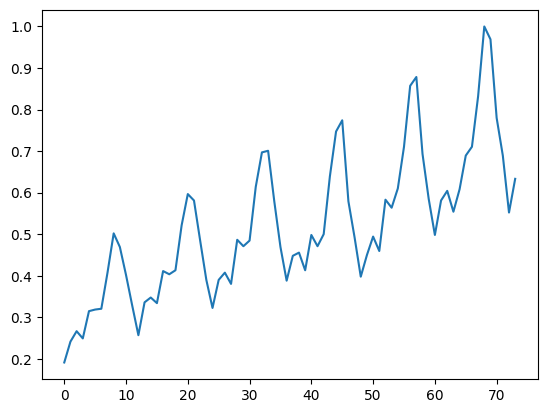

In [16]:
plt.figure()
plt.plot(training_data[-(batch_size-1):])

generated_series:  torch.Size([75, 32, 1])


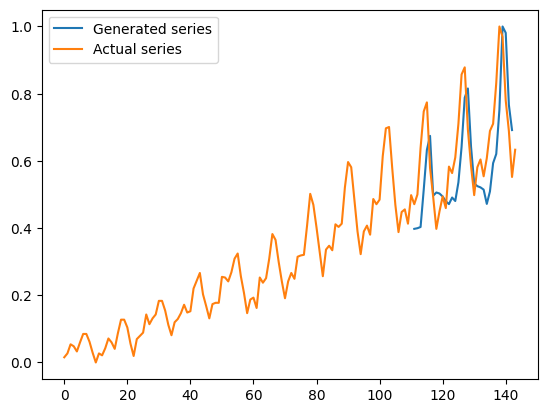

Parameter containing:
tensor([-0.0100], requires_grad=True)


In [57]:
with torch.no_grad():
    
    
    generated_series = G(dataX[len(dataX)-batch_size:]) #substitue trainX with testX
    generated_series=generated_series.permute(0,2,1)
    print("generated_series: ",generated_series.shape)
    generated_series = generated_series.detach().numpy()

sc = MinMaxScaler((training_data[batch_size+seq_length:].min(axis=0),training_data[batch_size+seq_length:].max(axis=0)))
generated_series[batch_size-1] = sc.fit_transform(generated_series[batch_size-1])


plt.figure()
plt.plot(range(len(training_data)-seq_length-1,len(training_data)-1),generated_series[batch_size-1], label='Generated series')
plt.plot(training_data[:], label='Actual series')

plt.legend()
plt.show()

print(G.main.attn.gamma)

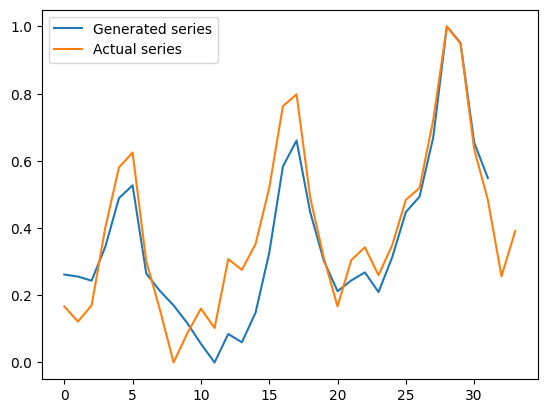

In [54]:
aux=utils.scale(training_data[batch_size+seq_length+3:])

plt.figure()
plt.plot(utils.scale(generated_series[batch_size-1]), label='Generated series')
plt.plot(aux, label='Actual series')

plt.legend()
plt.show()

